In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#forecasting tools
from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
#from pmdarima import auto_arima # for determining ARIMA orders

#Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")


In [2]:
#Making 'Date' as the index column
df=pd.read_csv('time-series-19-covid-combined.csv',index_col='Date',parse_dates=True)




In [3]:
df.head()

,Country/Region,Province/State,Lat,Long,Confirmed,Recovered,Deaths
Date,,,,,,,
2020-01-22,Afghanistan,NaN,33.0,65.0,0.0,0.0,0.0
2020-01-23,Afghanistan,NaN,33.0,65.0,0.0,0.0,0.0
2020-01-24,Afghanistan,NaN,33.0,65.0,0.0,0.0,0.0
2020-01-25,Afghanistan,NaN,33.0,65.0,0.0,0.0,0.0
2020-01-26,Afghanistan,NaN,33.0,65.0,0.0,0.0,0.0


In [4]:
#Selecting the US
df_US=df[df['Country/Region']=='US']

In [5]:
#Setting frequency to Daily
df_US.index.freq='D'

In [6]:
#Dropping Unecessary Columns
df_US.drop(['Country/Region', 'Province/State', 'Lat', 'Long'],axis=1,inplace=True)

In [7]:
#Dropping null values
df_US.dropna()
df_US.tail()

,Confirmed,Recovered,Deaths
Date,,,
2020-03-29,140886.0,2665.0,2467.0
2020-03-30,161807.0,5644.0,2978.0
2020-03-31,188172.0,7024.0,3873.0
2020-04-01,213372.0,8474.0,4757.0
2020-04-02,243453.0,9001.0,5926.0


# Visualizing

In [8]:
latest_val=df.groupby('Country/Region')['Confirmed'].max().sort_values(ascending=False)
latest_deaths=df.groupby('Country/Region')['Deaths'].max().sort_values(ascending=False)

In [9]:
latest_val.head()

Country/Region
US         243453.0
Italy      115242.0
Spain      112065.0
Germany     84794.0
China       67802.0
Name: Confirmed, dtype: float64

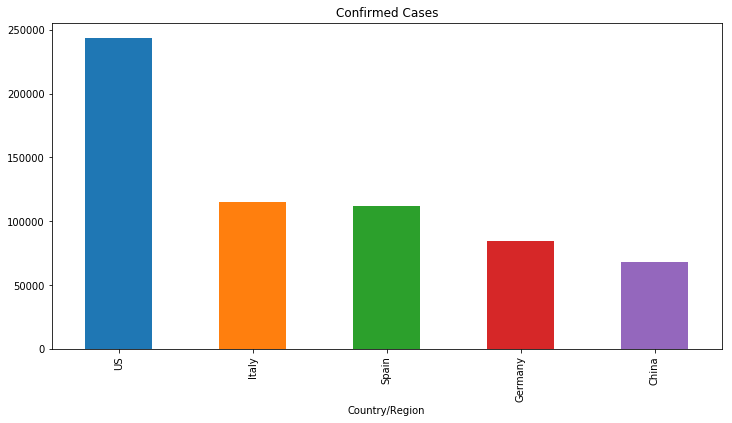

In [14]:
plt.figure(figsize=(12,6))
latest_val.head().plot(kind='bar',title='Confirmed Cases')

plt.show()

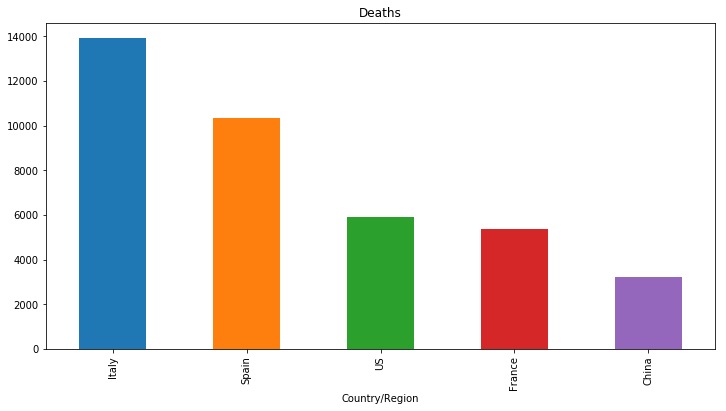

In [15]:
plt.figure(figsize=(12,6))
latest_deaths.head().plot(kind='bar',title='Deaths')

plt.show()

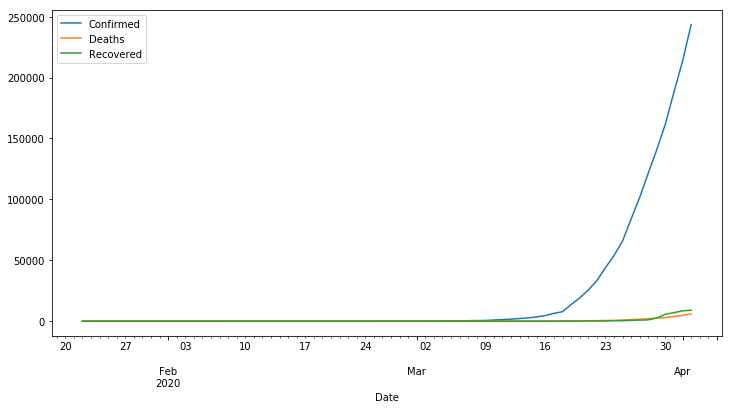

In [8]:
#Plotting Features
df_US['Confirmed'].plot(figsize=(12,6),legend=True)
df_US['Deaths'].plot(figsize=(12,6),legend=True)
df_US['Recovered'].plot(figsize=(12,6),legend=True)

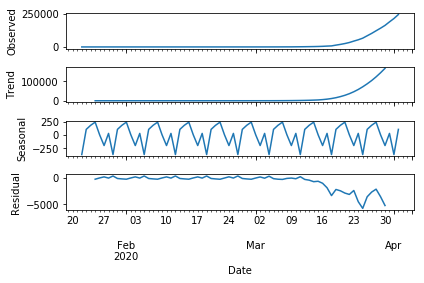

In [9]:
#### ETS Decomposition to Check seasonality
from statsmodels.tsa.seasonal import seasonal_decompose
results=seasonal_decompose(df_US['Confirmed'])
results.plot();

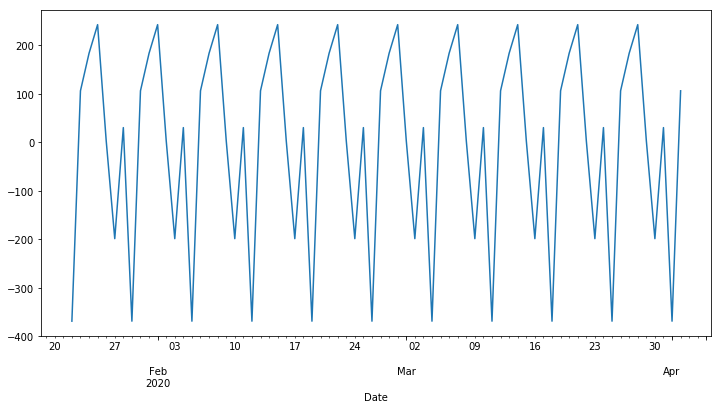

In [10]:
results.seasonal.plot(figsize=(12,6))

# Deriving p,d,q values(The Orders for the Model)

# Checking For Stationarity

In [11]:
#Augmented Dickey Fuller Test

from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') 
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())         
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [13]:
#Running the augmented Dickey-Fuller Test after 5 differences to confirm stationarity
adf_test(df_US['diff'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -23.183871
p-value                  0.000000
# lags used              8.000000
# observations          58.000000
critical value (1%)     -3.548494
critical value (5%)     -2.912837
critical value (10%)    -2.594129
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


After 5 differences we reached stationarity

# Differencing

In [12]:
from statsmodels.tsa.statespace.tools import diff
df_US['diff'] = diff(df_US['Confirmed'],k_diff=5)

# Equivalent to:
# df_US['Confirmed'] = df_US['Confirmed'] - df_US['COnfirmed'].shift(5)


# ACF and PACF plots 

A PACF Plot can identify AR(p) orders, and an ACF Plot can do the same for MA(q) orders.If the PACF displays a sharp cutoff while the ACF decays more slowly, we say that the stationarized series displays an "AR signature," meaning that the autocorrelation pattern can be explained more easily by adding AR terms than by adding MA terms.

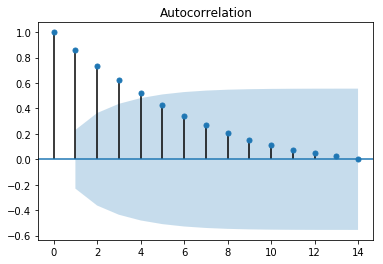

In [10]:
lags = 14
plot_acf(df_US['Confirmed'],lags=lags);

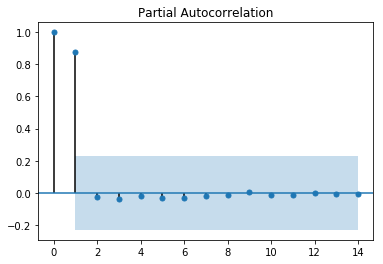

In [11]:
plot_pacf(df_US['Confirmed'],lags=lags);

Looking at the graph, PACF displays a sharp cutoff while the ACF decays more slowly, we say that the stationarized series displays an AR signature, however we have to check all the possible models with values of p,d,q. This can be done by the autoarima function which compares the AIC and BIC criteria and selects the best model.

We can look for the summary for the orders.


# auto_arima function to select the orders

In [33]:
stepwise= auto_arima(df_US['Confirmed'], start_p=0, start_q=0,
                          max_p=2, max_q=2,
                          seasonal=True,m=7,
                          d=None, trace=True,
                          error_action='ignore',   
                          suppress_warnings=True, 
                          stepwise=True)           
stepwise.summary()

Fit ARIMA: order=(0, 2, 0) seasonal_order=(1, 0, 1, 7); AIC=1192.444, BIC=1201.437, Fit time=0.353 seconds
Fit ARIMA: order=(0, 2, 0) seasonal_order=(0, 0, 0, 7); AIC=1208.647, BIC=1213.144, Fit time=0.011 seconds
Fit ARIMA: order=(1, 2, 0) seasonal_order=(1, 0, 0, 7); AIC=1188.172, BIC=1197.166, Fit time=0.158 seconds
Fit ARIMA: order=(0, 2, 1) seasonal_order=(0, 0, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 2, 0) seasonal_order=(0, 0, 0, 7); AIC=1210.323, BIC=1217.069, Fit time=0.019 seconds
Fit ARIMA: order=(1, 2, 0) seasonal_order=(2, 0, 0, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 2, 0) seasonal_order=(1, 0, 1, 7); AIC=1189.846, BIC=1201.088, Fit time=0.345 seconds
Fit ARIMA: order=(1, 2, 0) seasonal_order=(2, 0, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 2, 0) seasonal_order=(1, 0, 0, 7); AIC=1190.744, BIC=1197.489, Fit time=0.199 seconds
Fit ARIMA: order=(2, 2, 0) seasonal_order=(1, 0, 0, 7); AIC=1189.859, BIC

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                                 y   No. Observations:                   72
Model:             SARIMAX(1, 2, 0)x(1, 0, 0, 7)   Log Likelihood                -590.086
Date:                           Wed, 22 Apr 2020   AIC                           1188.172
Time:                                   08:53:51   BIC                           1197.166
Sample:                                        0   HQIC                          1191.745
                                            - 72                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    382.5532    303.994      1.258      0.208    -213.264     978.370
ar.L1         -0.2764      0.141     -1.963      0.050      -0.552      -0.000
ar.S.L7        0.6485      0.115      5.662      0.000       0.424       0.873
sigma2      1.155e+06   1.76e+05      6.573      0.000    8.11e+05     1.5e+06
===================================================================================
Ljung-Box (Q):                       38.36   Jarque-Bera (JB):               496.38
Prob(Q):                              0.54   Prob(JB):                         0.00
Heteroskedasticity (H):              19.57   Skew:                             3.26
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

According to the test a SARIMAX(1, 2, 0)x(1, 0, 0, 7) would be appropriate for prediction.

# Splitting Data into Training and Testing

In [34]:
train=df_US.iloc[:65]
test=df_US.iloc[65:]

# Fitting the Model

In [35]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
Model=SARIMAX(train['Confirmed'],order=(1,2,0),seasonal_order=(1,2,0,7),enforce_invertibility=False).fit()

# Prediction on test

In [1]:
Predictions=Model.predict(start=len(train),end=len(train)+len(test)-1,typ='levels').rename('US_SARIMAX')

NameError: name 'Model' is not defined

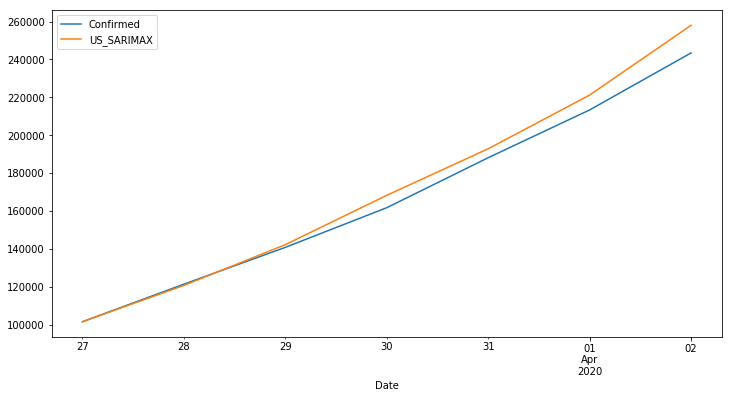

In [37]:
test['Confirmed'].plot(figsize=(12,6),legend=True)
Predictions.plot(legend=True)

# Evaluation

In [38]:
Predictions.describe()

count         7.000000
mean     172175.401054
std       55860.978817
min      101646.432502
25%      131560.156965
50%      168329.606695
75%      207056.500212
max      258018.453829
Name: US_SARIMAX, dtype: float64

In [39]:
test['Confirmed'].describe()

count         7.000000
mean     167260.714286
std       50816.778318
min      101657.000000
25%      131182.000000
50%      161807.000000
75%      200772.000000
max      243453.000000
Name: Confirmed, dtype: float64

In [40]:
from statsmodels.tools.eval_measures import rmse
rmse(test['Confirmed'],Predictions)

6979.630972270902

# Forecasting the next week

In [187]:
Final_model=SARIMAX(df_US['Confirmed'],order=(1,2,0),seasonal_order=(1,2,0,7),enforce_invertibility=False).fit()

In [200]:
final_preds=Final_model.predict(start=len(df_US)-1,end=len(df_US)+30,typ='levels').rename('FINAL_PREDICTIONS')

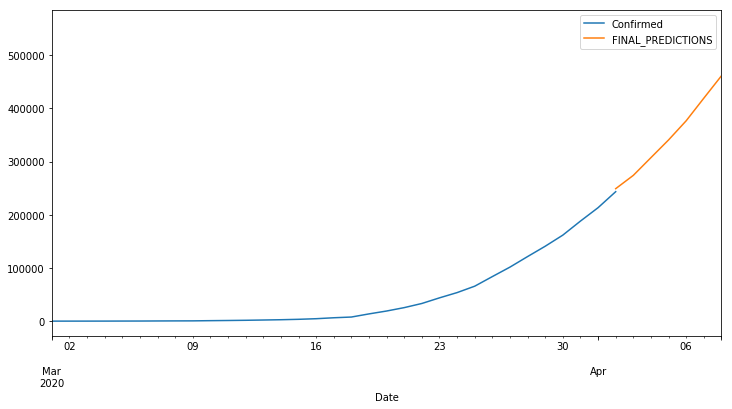

In [201]:
df_US['Confirmed'].plot(figsize=(12,6),legend=True,xlim=('2020-03-01','2020-04-08'))
final_preds.plot(legend=True)

In [202]:
final_preds

2020-04-02    249104.569506
2020-04-03    274124.594799
2020-04-04    307467.481401
2020-04-05    340722.430207
2020-04-06    376753.492680
2020-04-07    419203.170961
2020-04-08    461241.072304
2020-04-09    508836.479568
2020-04-10    557439.839184
Freq: D, Name: FINAL_PREDICTIONS, dtype: float64